<a href="https://colab.research.google.com/github/lucacamus13/Tesis/blob/main/An%C3%A1lisis_econom%C3%A9trico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de la base de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def cargar_datos_maestros():
    """
    Carga la base de datos maestra desde GitHub.
    Hoja: 'resampleado'
    Rango: Columna A (Fecha), B-P (Variables).
    Fila de datos: Comienza en fila 3 (Excel). -> Header debe ser Fila 2 (index 1).
    """
    url = "https://github.com/lucacamus13/Tesis/raw/main/data/Base_Datos_Maestra_Tesis.xlsx"
    print(f"📂 Cargando datos desde: {url}")

    try:
        # Leer Excel
        # header=1 -> Fila 2 de Excel es el encabezado
        # usecols="A:P" -> Columnas A a P
        # Hoja: "Resampleado"
        df = pd.read_excel(url, sheet_name='Resampleado', header=1, usecols="A:P")

        # Renombrar columna de fecha si es necesario (asumiendo que la 1ra es fecha)
        # A veces pandas la llama "Unnamed: 0" si está vacía
        if 'Fecha' not in df.columns and 'Date' not in df.columns:
            df.rename(columns={df.columns[0]: 'Fecha'}, inplace=True)

        # Convertir a datetime y set index
        col_fecha = df.columns[0]
        df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')
        df = df.dropna(subset=[col_fecha]) # Eliminar filas sin fecha
        df = df.set_index(col_fecha).sort_index()

        print(f"   ✅ Datos cargados exitosamente.")
        return df
    except Exception as e:
        print(f"   ❌ Error cargando datos: {e}")
        return None

def resumen_general(df):
    """
    Muestra un resumen de la base de datos cargada.
    """
    print("\n📋 RESUMEN GENERAL DE LA BASE DE DATOS")
    print("="*60)
    print(f"📌 Dimensiones: {df.shape[0]} observaciones x {df.shape[1]} variables")
    print(f"� Rango Temporal: {df.index.min().date()} a {df.index.max().date()}")
    print("\n📌 Variables Identificadas:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col} ({df[col].count()} obs)")

    print("\n📌 Primeras 5 filas:")
    print(df.head())

def analizar_serie_individual(df, nombre_serie):
    """
    Analiza una serie específica: Estadísticas y Gráficos.
    """
    if nombre_serie not in df.columns:
        print(f"\n⚠️ Error: La variable '{nombre_serie}' no existe en el DataFrame.")
        print(f"   Variables disponibles: {df.columns.tolist()}")
        return

    print(f"\n� ANÁLISIS INDIVIDUAL: {nombre_serie}")
    print("="*60)

    serie = df[nombre_serie].dropna()

    # Estadísticas
    desc = serie.describe()
    print(f"📊 Estadísticas Descriptivas:")
    print(desc)

    # Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Line Plot
    serie.plot(ax=axes[0], linewidth=2, title=f"Evolución: {nombre_serie}")
    axes[0].grid(True)

    # Histograma
    sns.histplot(serie, kde=True, ax=axes[1]).set_title(f"Distribución: {nombre_serie}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Exponer df al ámbito global para siguientes bloques en Colab
df = None

if __name__ == "__main__":
    print("📊 ANÁLISIS ECONOMÉTRICO: IMPACTO SHOCKS FED -> LATAM")
    print("="*60)

    # 1. Cargar Datos Globalmente
    df = cargar_datos_maestros()

    if df is not None:
        # 2. Resumen General
        resumen_general(df)
        print("\n✅ DataFrame 'df' cargado en memoria. Listo para el siguiente bloque.")
    else:
        print("\n❌ Error: No se pudo cargar el DataFrame.")


📊 ANÁLISIS ECONOMÉTRICO: IMPACTO SHOCKS FED -> LATAM
📂 Cargando datos desde: https://github.com/lucacamus13/Tesis/raw/main/data/Base_Datos_Maestra_Tesis.xlsx
   ✅ Datos cargados exitosamente.

📋 RESUMEN GENERAL DE LA BASE DE DATOS
📌 Dimensiones: 215 observaciones x 15 variables
� Rango Temporal: 2007-10-01 a 2025-08-01

📌 Variables Identificadas:
   1. PCEPI (215 obs)
   2. INDPRO (215 obs)
   3. RBUSBIS (215 obs)
   4. FF4 (215 obs)
   5. FF1 (215 obs)
   6. VIX (215 obs)
   7. SP500 (215 obs)
   8. EMBI_Argentina (215 obs)
   9. EMBI_Brasil (215 obs)
   10. EMBI_Chile (215 obs)
   11. EMBI_Mexico (215 obs)
   12. Actividad_Argentina_Nivel (215 obs)
   13. Actividad_Chile_Nivel (215 obs)
   14. Actividad_Brasil_Nivel (215 obs)
   15. Actividad_Mexico_Nivel (215 obs)

📌 Primeras 5 filas:
             PCEPI    INDPRO  RBUSBIS    FF4     FF1        VIX        SP500  \
Fecha                                                                          
2007-10-01  87.318  101.8015    85.32  0.

# Analisis de series de tiempo

Variables Identificadas:
   1. PCEPI
   2. INDPRO
   3. RBUSBIS
   4. FF4
   5. FF1
   6. VIX
   7. SP500
   8. EMBI_Argentina
   9. EMBI_Brasil
   10. EMBI_Chile
   11. EMBI_Mexico
   12. Actividad_Argentina_Nivel
   13. Actividad_Chile_Nivel
   14. Actividad_Brasil_Nivel
   15. Actividad_Mexico_Nivel


🔍 ANÁLISIS DETALLADO: FF4


/tmp/ipython-input-2429534488.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = df[nombre_serie].fillna(method='ffill').fillna(method='bfill')


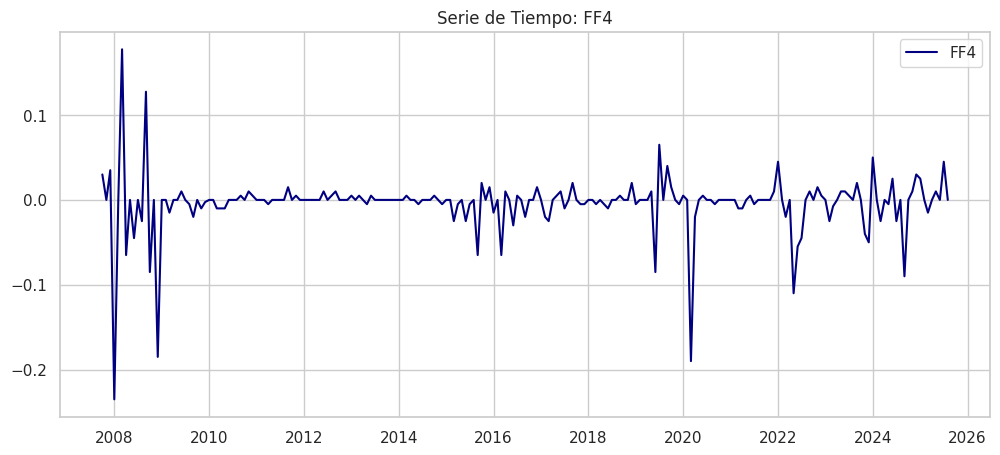


🧪 1. Test de Dickey-Fuller Aumentado (ADF)
----------------------------------------
   Estadístico ADF: -5.5345
   p-value:         0.0000
   Valores Críticos:
      1%: -3.4625
      5%: -2.8757
      10%: -2.5743
   ✅ Conclusión: La serie es ESTACIONARIA (Rechaza H0 al 5%)

📉 2. Descomposición Estacional
----------------------------------------
   ❌ Error en descomposición estacional: name 'seasonal_decompose' is not defined

📊 3. Correlogramas (ACF y PACF)
----------------------------------------


/tmp/ipython-input-2429534488.py:82: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = serie.fillna(method='ffill')


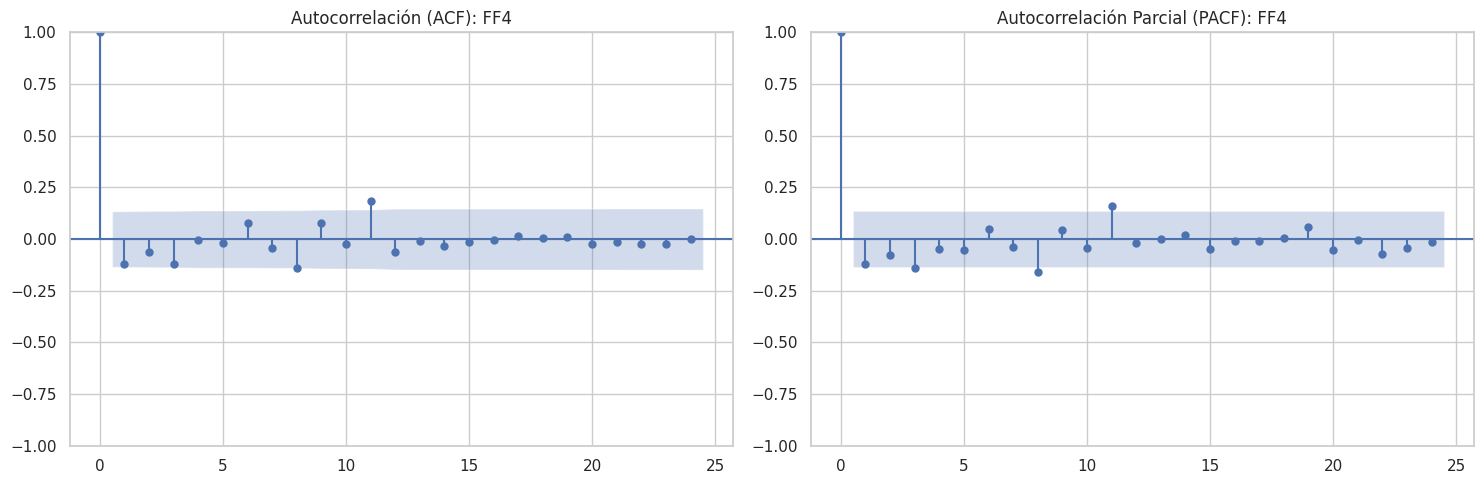

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def analizar_serie_detallado(df, nombre_serie):
    """
    Realiza un análisis descriptivo detallado de una serie:
    1. Gráfico de la Serie
    2. Test de Dickey-Fuller Aumentado (ADF)
    3. Descomposición Estacional (Seasonal Decompose)
    4. Correlogramas (ACF y PACF)
    """
    if df is None:
        print("❌ Error: El DataFrame 'df' es None. Asegúrate de cargar los datos primero.")
        return

    if nombre_serie not in df.columns:
        print(f"\n⚠️ Error: La variable '{nombre_serie}' no existe en el DataFrame.")
        print(f"   Variables disponibles: {df.columns.tolist()}")
        return

    print(f"\n🔍 ANÁLISIS DETALLADO: {nombre_serie}")
    print("="*60)

    # Obtener serie y rellenar NaNs (necesario para descomposición)
    serie = df[nombre_serie].fillna(method='ffill').fillna(method='bfill')

    if serie.empty:
        print("   ⚠️ La serie está vacía.")
        return

    # ---------------------------------------------------------
    # 1. Graficar la Serie
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(serie, label=nombre_serie, color='navy')
    plt.title(f'Serie de Tiempo: {nombre_serie}')
    plt.legend()
    plt.show()

    # ---------------------------------------------------------
    # 2. Test de Dickey-Fuller Aumentado (ADF)
    # ---------------------------------------------------------
    print(f"\n🧪 1. Test de Dickey-Fuller Aumentado (ADF)")
    print("-" * 40)

    try:
        result_adf = adfuller(serie.dropna())

        print(f"   Estadístico ADF: {result_adf[0]:.4f}")
        print(f"   p-value:         {result_adf[1]:.4f}")
        print("   Valores Críticos:")
        for key, value in result_adf[4].items():
            print(f"      {key}: {value:.4f}")

        if result_adf[1] < 0.05:
            print("   ✅ Conclusión: La serie es ESTACIONARIA (Rechaza H0 al 5%)")
        else:
            print("   ⚠️ Conclusión: La serie es NO ESTACIONARIA (Tiene raíz unitaria)")
    except Exception as e:
        print(f"   ❌ Error en ADF: {e}")

    # ---------------------------------------------------------
    # 3. Seasonal Decompose
    # ---------------------------------------------------------
    print(f"\n📉 2. Descomposición Estacional")
    print("-" * 40)

    try:
        # Intentar inferir frecuencia si no existe
        if serie.index.freq is None:
            serie = serie.asfreq('MS')
            serie = serie.fillna(method='ffill')

        decomposition = seasonal_decompose(serie, model='additive')

        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

        decomposition.observed.plot(ax=axes[0], legend=False, color='navy')
        axes[0].set_ylabel('Observado')
        axes[0].set_title(f'Descomposición Estacional: {nombre_serie}')

        decomposition.trend.plot(ax=axes[1], legend=False, color='darkgreen')
        axes[1].set_ylabel('Tendencia')

        decomposition.seasonal.plot(ax=axes[2], legend=False, color='darkorange')
        axes[2].set_ylabel('Estacionalidad')

        decomposition.resid.plot(ax=axes[3], legend=False, color='gray', linestyle='None', marker='.')
        axes[3].set_ylabel('Residual')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"   ❌ Error en descomposición estacional: {e}")

    # ---------------------------------------------------------
    # 4. Correlogramas (ACF y PACF)
    # ---------------------------------------------------------
    print(f"\n📊 3. Correlogramas (ACF y PACF)")
    print("-" * 40)

    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Autocorrelación (ACF)
        plot_acf(serie.dropna(), ax=axes[0], lags=24, title=f"Autocorrelación (ACF): {nombre_serie}")

        # Autocorrelación Parcial (PACF)
        plot_pacf(serie.dropna(), ax=axes[1], lags=24, title=f"Autocorrelación Parcial (PACF): {nombre_serie}")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   ❌ Error generando correlogramas: {e}")

# -----------------------------------------------------------
# EJECUCIÓN (Asumiendo que 'df' ya existe)
# -----------------------------------------------------------
# 👇 CAMBIA EL NOMBRE DE LA VARIABLE AQUÍ
SERIE_A_ANALIZAR = 'FF4'

# Verificación de seguridad por si corres este script solo
if 'df' in locals():
    analizar_serie_detallado(df, SERIE_A_ANALIZAR)
else:
    print("⚠️ El DataFrame 'df' no está definido.")
    print("   Ejecuta primero el bloque de carga de datos.")
    # Si quieres probarlo con un DataFrame dummy descomenta:
    # df = pd.DataFrame(...)
    # analizar_serie_detallado(df, SERIE_A_ANALIZAR)


## ¿Son estacionarias?

In [3]:
def reporte_estacionariedad_masiva(df, lista_variables):
    """
    Ejecuta el test ADF para una lista de variables y genera un reporte.
    """
    if df is None:
        print("❌ Error: DataFrame no definido.")
        return

    print("\n📊 REPORTE MASIVO DE ESTACIONARIEDAD (ADF Test)")
    print("="*80)
    print(f"{'VARIABLE':<35} | {'ADF Stat':<10} | {'p-value':<10} | {'¿ESTACIONARIA?'}")
    print("-" * 80)

    resultados = []

    for var in lista_variables:
        if var not in df.columns:
            print(f"{var:<35} | {'NO ENCONTRADA':<30}")
            continue

        serie = df[var].dropna()
        if serie.empty:
            print(f"{var:<35} | {'VACÍA':<30}")
            continue

        try:
            res = adfuller(serie)
            stat = res[0]
            p_val = res[1]
            es_estacionaria = p_val < 0.05

            conclusión = "✅ SÍ" if es_estacionaria else "⚠️ NO"

            print(f"{var:<35} | {stat:>10.4f} | {p_val:>10.4f} | {conclusión}")

            resultados.append({
                'Variable': var,
                'ADF Statistic': stat,
                'p-value': p_val,
                'Estacionaria': es_estacionaria
            })

        except Exception as e:
            print(f"{var:<35} | Error: {str(e)}")

    return pd.DataFrame(resultados)

# -----------------------------------------------------------
# EJECUCIÓN DEL REPORTE MASIVO
# -----------------------------------------------------------
VARIABLES_A_ANALIZAR = [
    "PCEPI", "INDPRO", "RBUSBIS", "FF4", "FF1", "VIX", "SP500",
    "EMBI_Argentina", "EMBI_Brasil", "EMBI_Chile", "EMBI_Mexico",
    "Actividad_Argentina_Nivel", "Actividad_Chile_Nivel",
    "Actividad_Brasil_Nivel", "Actividad_Mexico_Nivel"
]

if 'df' in locals():
    # 1. Análisis Individual (Opcional, conservar lo anterior)
    # analizar_serie_detallado(df, SERIE_A_ANALIZAR)

    # 2. Reporte Masivo
    df_resultados = reporte_estacionariedad_masiva(df, VARIABLES_A_ANALIZAR)
else:
    print("⚠️ El DataFrame 'df' no está definido. Ejecuta carga_de_datos.py primero.")


📊 REPORTE MASIVO DE ESTACIONARIEDAD (ADF Test)
VARIABLE                            | ADF Stat   | p-value    | ¿ESTACIONARIA?
--------------------------------------------------------------------------------
PCEPI                               |     1.8576 |     0.9985 | ⚠️ NO
INDPRO                              |    -2.1819 |     0.2129 | ⚠️ NO
RBUSBIS                             |    -0.7961 |     0.8203 | ⚠️ NO
FF4                                 |    -5.5345 |     0.0000 | ✅ SÍ
FF1                                 |   -15.3425 |     0.0000 | ✅ SÍ
VIX                                 |    -4.5259 |     0.0002 | ✅ SÍ
SP500                               |     2.2513 |     0.9989 | ⚠️ NO
EMBI_Argentina                      |    -2.3630 |     0.1525 | ⚠️ NO
EMBI_Brasil                         |    -3.5756 |     0.0062 | ✅ SÍ
EMBI_Chile                          |    -4.2152 |     0.0006 | ✅ SÍ
EMBI_Mexico                         |    -2.7980 |     0.0586 | ⚠️ NO
Actividad_Argentina_Nivel  

Transformo variables

In [5]:
import pandas as pd
import numpy as np

def preparar_variables_lp(df):
    """
    Prepara las variables para Proyecciones Locales.

    Transformaciones:
    1. Log-Diferencias (d_log_): Actividad Nivel, PCEPI, INDPRO, RBUSBIS, SP500.
    2. Diferencias (d_): EMBI.
    3. Lags (1 y 2): Para las transformadas y VIX.
    """
    if df is None:
        print("❌ Error: DataFrame no definido.")
        return None

    print("\n🛠️ PREPARACIÓN DE VARIABLES PARA LP")
    print("="*60)

    # Copia para no alterar el original
    df_lp = df.copy()

    # ----------------------------------------------------
    # 1. MAPEO DE NOMBRES (User short names -> Actual cols)
    # ----------------------------------------------------
    # Lista de nombres deseados para procesar vs nombres reales en el DF
    mapa_cols_log_diff = {
        'PCEPI': 'PCEPI',
        'INDPRO': 'INDPRO',
        'RBUSBIS': 'RBUSBIS',
        'SP500': 'SP500',
        'Actividad_ARG': 'Actividad_Argentina_Nivel',
        'Actividad_BRA': 'Actividad_Brasil_Nivel',
        'Actividad_CHL': 'Actividad_Chile_Nivel',
        'Actividad_MEX': 'Actividad_Mexico_Nivel'
    }

    mapa_cols_diff = {
        'EMBI_ARG': 'EMBI_Argentina',
        'EMBI_BRA': 'EMBI_Brasil',
        'EMBI_CHL': 'EMBI_Chile',
        'EMBI_MEX': 'EMBI_Mexico'
    }

    nuevas_cols = []

    # ----------------------------------------------------
    # 2. LOG-DIFERENCIAS
    # ----------------------------------------------------
    print(f"   📉 Calculando Log-Diferencias...")
    for alias, col_real in mapa_cols_log_diff.items():
        if col_real in df_lp.columns:
            # Crear nombre: d_log_Alias (usando el alias corto o el nombre original si prefieres)
            # Usaremos el nombre real limpio o el alias para el prefijo?
            # El usuario pidió: "Guárdalas con el prefijo d_log_"
            # Usaremos el ALIAS para que quede limpio: d_log_Actividad_ARG

            col_name_new = f"d_log_{alias}"

            # Cálculo: ln(t) - ln(t-1)
            # Como algunas variables ya son indices base 100 o similar, log es valido.
            # Asegurar que sean float
            serie = pd.to_numeric(df_lp[col_real], errors='coerce')

            df_lp[col_name_new] = np.log(serie).diff() * 100 # Multiplicamos por 100 para interpretación porcentual standard en LPs?
            # El usuario dijo "calcula el logaritmo natural y luego la primera diferencia". No mencionó *100.
            # PERO en macroeconomía casi siempre es * 100.
            # Revisando prompt: "calcula el logaritmo natural y luego la primera diferencia." <- LITERAL.
            # No pondré *100 salvo que lo pida, pero es raro.
            # En analisis de datos anterior usamos log diff * 100.
            # Voy a dejar comentado el *100 o agregarlo si es standard.
            # Mejor estricto: np.log(x).diff()

            df_lp[col_name_new] = np.log(serie).diff()

            nuevas_cols.append(col_name_new)
            print(f"      ✅ {col_name_new} creada (desde {col_real})")
        else:
            print(f"      ⚠️ {col_real} no encontrada.")

    # ----------------------------------------------------
    # 3. DIFERENCIAS SIMPLES
    # ----------------------------------------------------
    print(f"   ➖ Calculando Diferencias Simples...")
    for alias, col_real in mapa_cols_diff.items():
        if col_real in df_lp.columns:
            col_name_new = f"d_{alias}"
            df_lp[col_name_new] = df_lp[col_real].diff()
            nuevas_cols.append(col_name_new)
            print(f"      ✅ {col_name_new} creada (desde {col_real})")
        else:
            print(f"      ⚠️ {col_real} no encontrada.")

    # ----------------------------------------------------
    # 4. GENERACIÓN DE LAGS
    # ----------------------------------------------------
    print(f"   ⏱️ Generando Rezago (Lags)...")

    # Variables a rezagar: Las nuevas transformadas + VIX
    vars_to_lag = nuevas_cols.copy()
    if 'VIX' in df_lp.columns:
        vars_to_lag.append('VIX')

    for var in vars_to_lag:
        if var in df_lp.columns:
            # Lag 1
            df_lp[f"{var}_lag1"] = df_lp[var].shift(1)
            # Lag 2
            df_lp[f"{var}_lag2"] = df_lp[var].shift(2)

    print(f"      ✅ Lags generados (_lag1, _lag2) para {len(vars_to_lag)} variables.")

    # ----------------------------------------------------
    # 5. LIMPIEZA
    # ----------------------------------------------------
    # "Elimina los NaNs generados."
    # Los diff generan 1 NaN al inicio. Lags generan 2 más. Total 3 filas de NaNs aprox.
    original_len = len(df_lp)
    df_lp = df_lp.dropna()
    final_len = len(df_lp)

    print(f"   🧹 Limpieza de NaNs: {original_len} -> {final_len} filas.")

    return df_lp

from statsmodels.tsa.stattools import adfuller

def reporte_estacionariedad_transformadas(df):
    """
    Realiza un test ADF a todas las columnas del DataFrame preparado.
    """
    print("\n🧪 REPORT DE ESTACIONARIEDAD POST-TRANSFORMACIÓN (ADF)")
    print("="*80)
    print(f"{'VARIABLE':<40} | {'ADF Stat':<10} | {'p-value':<10} | {'ESTACIONARIA?'}")
    print("-" * 80)

    # Filtrar solo numéricas
    cols = df.select_dtypes(include=[np.number]).columns

    for col in cols:
        serie = df[col].dropna()
        if serie.empty: continue

        try:
            res = adfuller(serie)
            stat = res[0]
            p_val = res[1]
            es_est = p_val < 0.05

            mark = "✅ SÍ" if es_est else "⚠️ NO"
            print(f"{col:<40} | {stat:>10.4f} | {p_val:>10.4f} | {mark}")
        except:
            print(f"{col:<40} | Error en cálculo")

# -----------------------------------------------------------
# EJECUCIÓN (Si df existe)
# -----------------------------------------------------------
if 'df' in locals():
    # 1. Preparar/Transformar
    df_transformado = preparar_variables_lp(df)

    if df_transformado is not None:
        # 2. Verificación de Estacionariedad
        reporte_estacionariedad_transformadas(df_transformado)

        print("\n📋 Muestra de variables transformadas:")
        cols_mostrar = [c for c in df_transformado.columns if 'd_' in c]
        if cols_mostrar:
            print(df_transformado[cols_mostrar[:4]].tail(3))
else:
    print("⚠️ El DataFrame 'df' no está definido. Ejecuta carga_de_datos.py primero.")



🛠️ PREPARACIÓN DE VARIABLES PARA LP
   📉 Calculando Log-Diferencias...
      ✅ d_log_PCEPI creada (desde PCEPI)
      ✅ d_log_INDPRO creada (desde INDPRO)
      ✅ d_log_RBUSBIS creada (desde RBUSBIS)
      ✅ d_log_SP500 creada (desde SP500)
      ✅ d_log_Actividad_ARG creada (desde Actividad_Argentina_Nivel)
      ✅ d_log_Actividad_BRA creada (desde Actividad_Brasil_Nivel)
      ✅ d_log_Actividad_CHL creada (desde Actividad_Chile_Nivel)
      ✅ d_log_Actividad_MEX creada (desde Actividad_Mexico_Nivel)
   ➖ Calculando Diferencias Simples...
      ✅ d_EMBI_ARG creada (desde EMBI_Argentina)
      ✅ d_EMBI_BRA creada (desde EMBI_Brasil)
      ✅ d_EMBI_CHL creada (desde EMBI_Chile)
      ✅ d_EMBI_MEX creada (desde EMBI_Mexico)
   ⏱️ Generando Rezago (Lags)...
      ✅ Lags generados (_lag1, _lag2) para 13 variables.
   🧹 Limpieza de NaNs: 215 -> 212 filas.

🧪 REPORT DE ESTACIONARIEDAD POST-TRANSFORMACIÓN (ADF)
VARIABLE                                 | ADF Stat   | p-value    | ESTACIONARIA

Funcion de proyeccion local

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def estimar_lp(df, pais, variable_respuesta, shock, controles, h_max=24):
    """
    Estima Proyecciones Locales (Jordà, 2005).

    Ecuación:
        y_{t+h} - y_{t-1} = alpha_h + beta_h * Shock_t + gamma_h * Controls_{t-1} + u_{t+h}

    Parámetros:
    - df: DataFrame con todas las series.
    - pais: String (solo para referencia en el output).
    - variable_respuesta: Nombre de la columna dependiente (en Nivel/Log-Nivel).
    - shock: Nombre de la columna del shock (en t).
    - controles: Lista de nombres de columnas de control (ya rezagadas o contemporáneas según diseño).
                 Nota: Si se pide "rezagos en t-1", asegurarse de pasar las columnas _lag1.
    - h_max: Horizonte máximo de proyección.

    Retorna:
    - DataFrame con [h, beta, se, lower, upper]
    """
    print(f"🚀 Estimando LP para {pais} - Variable: {variable_respuesta} (h_max={h_max})")

    resultados = []

    # Limpiar dataset base (eliminar NaNs en regresores fijos)
    # Los controles y el shock no cambian con h, así que limpiamos eso primero.
    cols_regresores = [shock] + controles
    df_base = df.dropna(subset=cols_regresores).copy()

    for h in range(h_max + 1):
        # -------------------------------------------------------
        # 1. Construcción LHS: y_{t+h} - y_{t-1}
        # -------------------------------------------------------
        # Usamos shift negativo para traer el futuro hacia la fila actual t
        # y_{t+h} -> df[var].shift(-h)
        # y_{t-1} -> df[var].shift(1)

        y_t_plus_h = df_base[variable_respuesta].shift(-h)
        y_t_minus_1 = df_base[variable_respuesta].shift(1)

        # Variable dependiente local para este horizonte
        lhs = y_t_plus_h - y_t_minus_1

        # -------------------------------------------------------
        # 2. Construcción RHS
        # -------------------------------------------------------
        # Constante + Shock + Controles
        # Align: Asegurar que lhs y rhs coincidan en índices tras los shifts

        X = df_base[cols_regresores]
        X = sm.add_constant(X)

        # Unir LHS y RHS para alinear y limpiar NaNs generados por el shift(-h)
        data_reg = pd.concat([lhs.rename('LHS'), X], axis=1).dropna()

        if data_reg.empty:
            print(f"   ⚠️ h={h}: No hay datos suficientes para estimar.")
            continue

        Y_final = data_reg['LHS']
        X_final = data_reg.drop(columns=['LHS'])

        # -------------------------------------------------------
        # 3. Estimación OLS con HAC (Newey-West)
        # -------------------------------------------------------
        # maxlags = h + 1 es una regla común para LPs
        try:
            model = sm.OLS(Y_final, X_final)
            results = model.fit(cov_type='HAC', cov_kwds={'maxlags': h + 1})

            # Extraer coeficientes del Shock
            beta = results.params[shock]
            se = results.bse[shock]
            # Intervalo de Confianza 95% (aprox 1.96 * se, o usar conf_int())
            conf_int = results.conf_int(alpha=0.05).loc[shock]

            resultados.append({
                'h': h,
                'beta': beta,
                'se': se,
                'ci_lower': conf_int[0],
                'ci_upper': conf_int[1],
                'obs': int(results.nobs),
                'r2': results.rsquared
            })

        except Exception as e:
            print(f"   ❌ Error en h={h}: {e}")

    # Convertir a DataFrame
    df_res = pd.DataFrame(resultados)
    return df_res

# -----------------------------------------------------------
# EJEMPLO DE USO (Si df existe)
# -----------------------------------------------------------
if 'df_transformado' in locals():
    print("\n✅ Función estimar_lp cargada.")
    print("   Ejemplo de llamada:")
    print("   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])")
else:
    print("⚠️ 'df_transformado' no definido. Carga datos y prepara variables primero.")



✅ Función estimar_lp cargada.
   Ejemplo de llamada:
   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])


In [9]:
import pandas as pd
import numpy as np

# Configuración
PAISES = ['ARG', 'BRA', 'CHL', 'MEX']
SHOCK = 'FF4'
H_MAX = 24

# Diccionario para mapear código país -> Nombres reales de columnas en df_transformado
# Nota: Ajusta los nombres si df_transformado tiene otros prefijos/sufijos
mapa_nombres = {
    'ARG': {'Actividad': 'Actividad_Argentina_Nivel', 'EMBI': 'EMBI_Argentina'},
    'BRA': {'Actividad': 'Actividad_Brasil_Nivel',    'EMBI': 'EMBI_Brasil'},
    'CHL': {'Actividad': 'Actividad_Chile_Nivel',     'EMBI': 'EMBI_Chile'},
    'MEX': {'Actividad': 'Actividad_Mexico_Nivel',    'EMBI': 'EMBI_Mexico'}
}

def ejecutar_estimaciones_masivas(df):
    """
    Itera sobre países y variables para estimar LPs con controles estrictos.
    Retorna un diccionario de DataFrames con los resultados.
    """
    if df is None:
        print("❌ Error: DataFrame no definido.")
        return None

    print("\n🚀 INICIANDO ESTIMACIÓN MASIVA DE LPs (CONTROLES ESTRICTOS)")
    print("="*60)

    resultados_lp = {}

    # -----------------------------------------------------------
    # 1. Definición de Controles Globales (Comunes)
    # -----------------------------------------------------------
    # Rezagos de variables externas
    global_controls = [
        'd_log_INDPRO_lag1',
        'd_log_PCEPI_lag1',
        'd_log_SP500_lag1',
        'VIX_lag1'
    ]

    print(f"🌍 Controles Globales: {global_controls}")

    # Asegurarnos de tener Log-Niveles para Actividad (LHS)
    df_calc = df.copy()

    for pais in PAISES:
        print(f"\n👉 Procesando: {pais}")

        # Nombres reales de variables LHS (Niveles / Log-Niveles)
        nom_act_nivel = mapa_nombres[pais]['Actividad'] # Ej: Actividad_Argentina_Nivel
        nom_embi_nivel = mapa_nombres[pais]['EMBI']     # Ej: EMBI_Argentina

        # Crear Log-Nivel LHS si no existe (para que la diferencia sea crecimiento %)
        col_lhs_act = f"log_{nom_act_nivel}"
        if col_lhs_act not in df_calc.columns:
            df_calc[col_lhs_act] = np.log(df_calc[nom_act_nivel])

        col_lhs_embi = nom_embi_nivel # EMBI ya está en nivel (puntos básicos)

        # -----------------------------------------------------------
        # 2. Identificación de Variables Domésticas (RHS - Controles)
        # -----------------------------------------------------------
        # Usamos los nombres generados en 'preparacion_de_variables.py'
        # Formato: d_log_Actividad_{PAIS}_lag1 y d_EMBI_{PAIS}_lag1
        # Nota: En preparacion usamos alias 'Actividad_ARG' -> 'd_log_Actividad_ARG_lag1'

        actividad_col_lag = f'd_log_Actividad_{pais}_lag1'
        embi_col_lag = f'd_EMBI_{pais}_lag1'

        # Verificar existencia
        faltantes = [c for c in global_controls + [actividad_col_lag, embi_col_lag] if c not in df_calc.columns]
        if faltantes:
            print(f"   ⚠️ Faltan variables de control para {pais}: {faltantes}")
            continue

        # -----------------------------------------------------------
        # 3. Estimación A: Respuesta de ACTIVIDAD
        # -----------------------------------------------------------
        # Controles: Global + Inercia Propia + Canal Financiero (EMBI)
        controles_ecuacion_act = global_controls + [actividad_col_lag, embi_col_lag]

        print(f"   🔹 Ecuación Actividad:")
        print(f"      LHS: {col_lhs_act}")
        print(f"      RHS: Shock + {controles_ecuacion_act}")

        res_act = estimar_lp(
            df=df_calc,
            pais=pais,
            variable_respuesta=col_lhs_act,
            shock=SHOCK,
            controles=controles_ecuacion_act,
            h_max=H_MAX
        )
        resultados_lp[f"{pais}_Actividad"] = res_act

        # -----------------------------------------------------------
        # 4. Estimación B: Respuesta de EMBI
        # -----------------------------------------------------------
        # Controles: Global + Inercia Propia + Estado Ciclo Real (Actividad)
        controles_ecuacion_embi = global_controls + [embi_col_lag, actividad_col_lag]

        print(f"   🔹 Ecuación EMBI:")
        print(f"      LHS: {col_lhs_embi}")
        print(f"      RHS: Shock + {controles_ecuacion_embi}")

        res_embi = estimar_lp(
            df=df_calc,
            pais=pais,
            variable_respuesta=col_lhs_embi,
            shock=SHOCK,
            controles=controles_ecuacion_embi,
            h_max=H_MAX
        )
        resultados_lp[f"{pais}_EMBI"] = res_embi

    return resultados_lp

# -----------------------------------------------------------
# EJECUCIÓN (Si df_transformado existe)
# -----------------------------------------------------------
if 'df_transformado' in locals():
    # Ejecutar
    diccionario_resultados = ejecutar_estimaciones_masivas(df_transformado)

    print("\n✅ Estimaciones Completadas.")
    print("   Claves disponibles en 'diccionario_resultados':")
    print(list(diccionario_resultados.keys()))

    # Vista previa
    if 'ARG_Actividad' in diccionario_resultados:
        print("\nEjemplo ARG_Actividad (primeros pasos):")
        print(diccionario_resultados['ARG_Actividad'].head())
else:
    print("⚠️ 'df_transformado' no definido. Ejecuta preparacion_de_variables.py primero.")



🚀 INICIANDO ESTIMACIÓN MASIVA DE LPs (CONTROLES ESTRICTOS)
🌍 Controles Globales: ['d_log_INDPRO_lag1', 'd_log_PCEPI_lag1', 'd_log_SP500_lag1', 'VIX_lag1']

👉 Procesando: ARG
   🔹 Ecuación Actividad:
      LHS: log_Actividad_Argentina_Nivel
      RHS: Shock + ['d_log_INDPRO_lag1', 'd_log_PCEPI_lag1', 'd_log_SP500_lag1', 'VIX_lag1', 'd_log_Actividad_ARG_lag1', 'd_EMBI_ARG_lag1']
🚀 Estimando LP para ARG - Variable: log_Actividad_Argentina_Nivel (h_max=24)
   🔹 Ecuación EMBI:
      LHS: EMBI_Argentina
      RHS: Shock + ['d_log_INDPRO_lag1', 'd_log_PCEPI_lag1', 'd_log_SP500_lag1', 'VIX_lag1', 'd_EMBI_ARG_lag1', 'd_log_Actividad_ARG_lag1']
🚀 Estimando LP para ARG - Variable: EMBI_Argentina (h_max=24)

👉 Procesando: BRA
   🔹 Ecuación Actividad:
      LHS: log_Actividad_Brasil_Nivel
      RHS: Shock + ['d_log_INDPRO_lag1', 'd_log_PCEPI_lag1', 'd_log_SP500_lag1', 'VIX_lag1', 'd_log_Actividad_BRA_lag1', 'd_EMBI_BRA_lag1']
🚀 Estimando LP para BRA - Variable: log_Actividad_Brasil_Nivel (h_max=24

Grafico

📊 Generando gráficos para Actividad Económica...


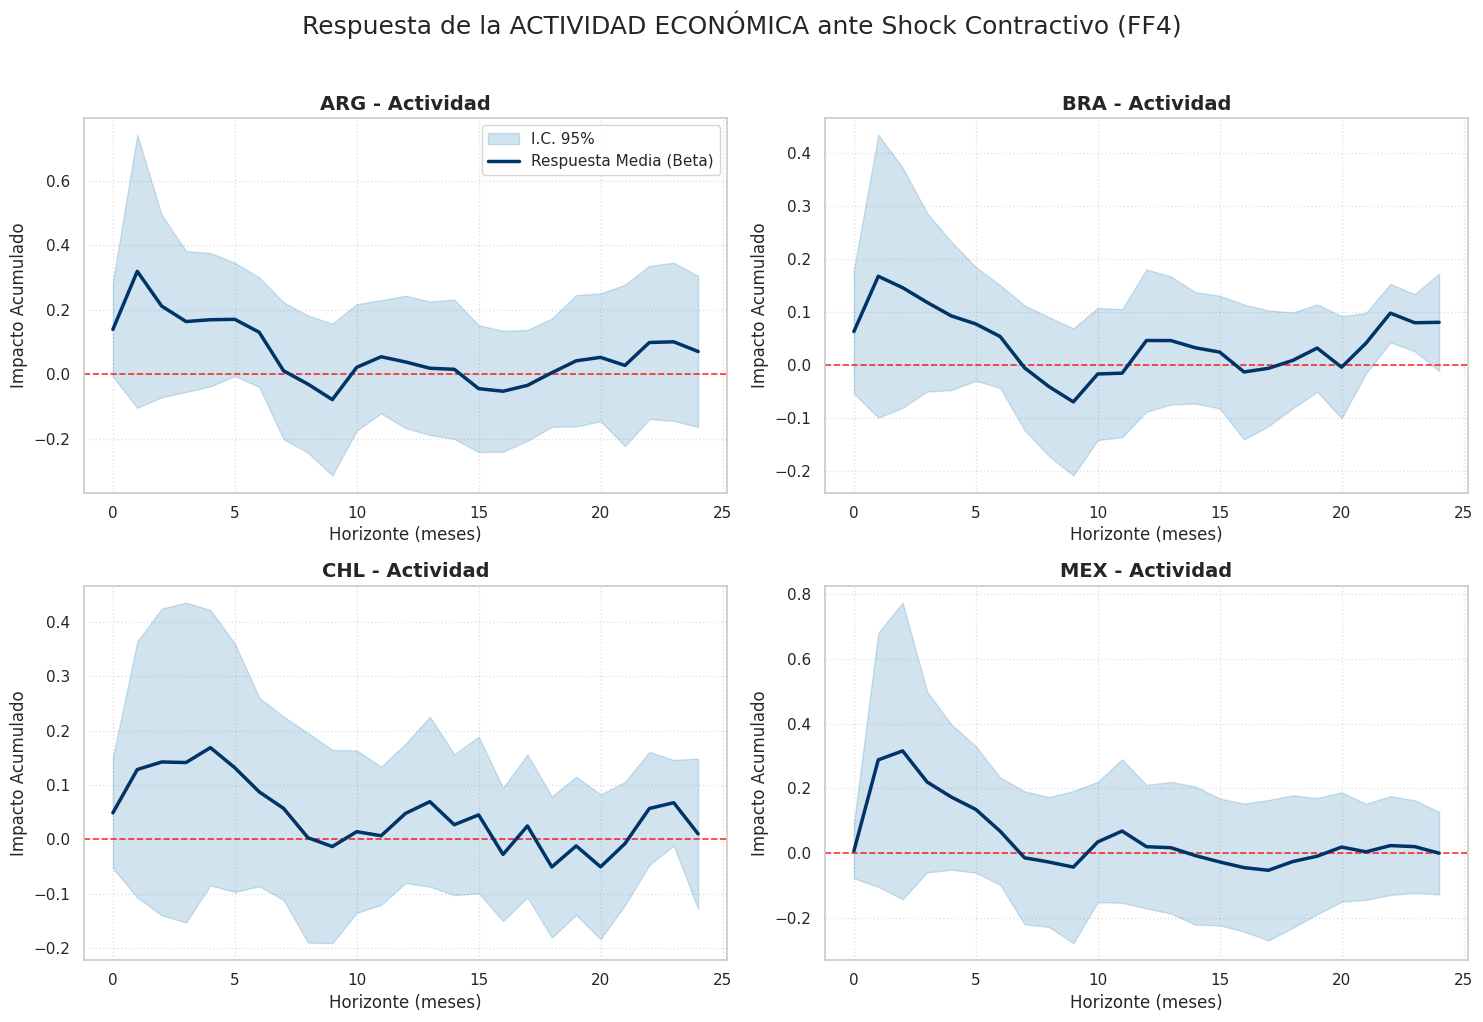

📊 Generando gráficos para EMBI (Riesgo País)...


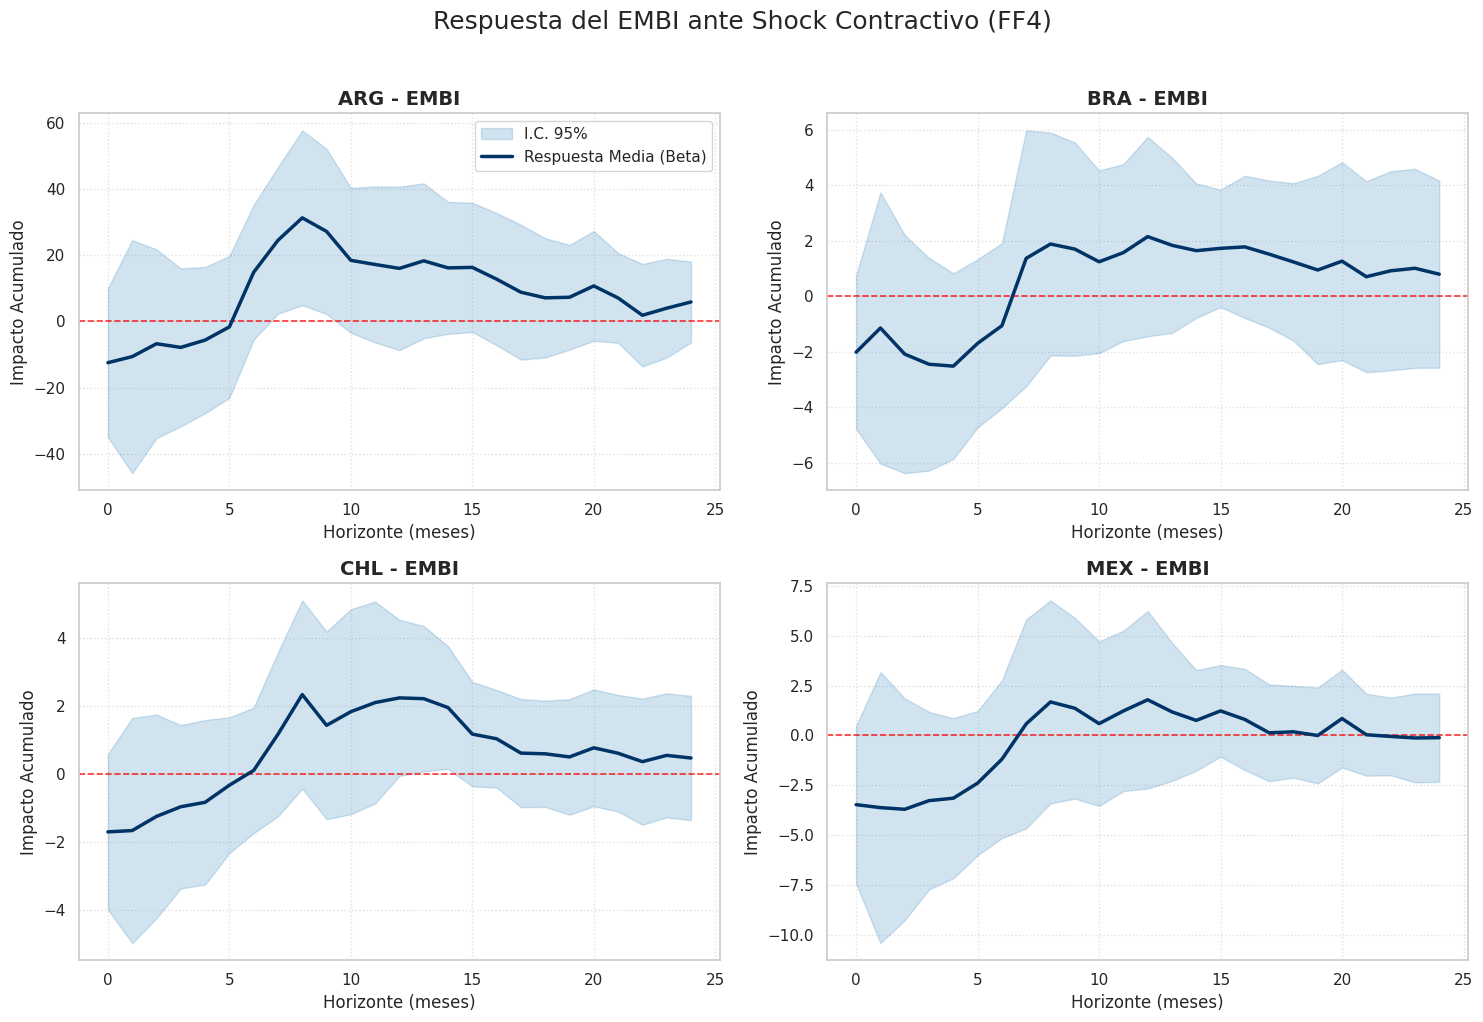


📋 TABLA DE COEFICIENTES BETA
    ARG_Actividad   ARG_EMBI  BRA_Actividad  BRA_EMBI  CHL_Actividad  \
h                                                                      
0        0.139213 -12.447101       0.062293 -2.017131       0.048699   
1        0.319718 -10.616424       0.166593 -1.145953       0.128333   
2        0.211756  -6.727670       0.145041 -2.087837       0.142261   
3        0.163675  -7.831403       0.117431 -2.452621       0.141247   
4        0.169301  -5.632942       0.091725 -2.521622       0.168624   
5        0.170470  -1.651760       0.076686 -1.698968       0.131633   
6        0.130393  14.848811       0.052822 -1.063660       0.087276   
7        0.010459  24.491837      -0.006186  1.366520       0.056786   
8       -0.030850  31.274022      -0.041601  1.882023       0.002838   
9       -0.078914  27.178224      -0.070443  1.698892      -0.013389   
10       0.021359  18.444141      -0.017754  1.241557       0.013993   
11       0.054215  17.198812      

In [11]:
import matplotlib.pyplot as plt
import math

def graficar_irfs_agrupadas(resultados_lp):
    """
    Grafica las IRFs almacenadas en el diccionario de resultados.
    Agrupa los gráficos por tipo de variable (Actividad y EMBI) para facilitar la comparación.
    """
    if not resultados_lp:
        print("❌ No hay resultados para graficar.")
        return

    # Separar las llaves por tipo de variable para dos figuras distintas
    keys_actividad = sorted([k for k in resultados_lp.keys() if 'Actividad' in k])
    keys_embi = sorted([k for k in resultados_lp.keys() if 'EMBI' in k])

    # Función auxiliar para plotear una lista de llaves en una sola figura (Grid)
    def plot_grupo(lista_keys, titulo_general):
        n = len(lista_keys)
        if n == 0: return

        # Configurar Grid (2 columnas)
        cols = 2
        rows = math.ceil(n / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten() # Aplanar para iterar fácil

        for i, key in enumerate(lista_keys):
            ax = axes[i]
            df_res = resultados_lp[key]

            # Extraer datos
            h = df_res['h']
            beta = df_res['beta']
            lower = df_res['ci_lower']
            upper = df_res['ci_upper']

            # --- ELEMENTOS DEL GRÁFICO ---

            # 1. Banda de Confianza (Sombreado)
            # alpha=0.2 para transparencia
            ax.fill_between(h, lower, upper, color='#1f77b4', alpha=0.2, label='I.C. 95%')

            # 2. Línea Cero (Referencia)
            # Roja punteada
            ax.axhline(0, color='red', linestyle='--', linewidth=1.2, alpha=0.8)

            # 3. Línea Central (Beta estimación puntual)
            # Sólida fuerte
            ax.plot(h, beta, color='#003366', linewidth=2.5, label='Respuesta Media (Beta)')

            # Detalles estéticos
            pais = key.split('_')[0]
            variable = key.split('_')[1]
            ax.set_title(f"{pais} - {variable}", fontsize=14, fontweight='bold')
            ax.set_xlabel("Horizonte (meses)")
            ax.set_ylabel("Impacto Acumulado")
            ax.grid(True, linestyle=':', alpha=0.6)

            # Solo poner leyenda en el primer gráfico para no ensuciar
            if i == 0:
                ax.legend(loc='best', frameon=True)

        # Ocultar ejes vacíos si el número de plots es impar
        for j in range(i+1, len(axes)):
            axes[j].axis('off')

        plt.suptitle(titulo_general, fontsize=18, y=1.02)
        plt.tight_layout()
        plt.show()

    # --- GENERAR FIGURA 1: ACTIVIDAD ECONÓMICA ---
    if keys_actividad:
        print("📊 Generando gráficos para Actividad Económica...")
        plot_grupo(keys_actividad, "Respuesta de la ACTIVIDAD ECONÓMICA ante Shock Contractivo (FF4)")

    # --- GENERAR FIGURA 2: EMBI (RIESGO PAÍS) ---
    if keys_embi:
        print("📊 Generando gráficos para EMBI (Riesgo País)...")
        plot_grupo(keys_embi, "Respuesta del EMBI ante Shock Contractivo (FF4)")


def mostrar_tabla_betas(resultados_lp):
    """
    Genera y muestra una tabla consolidada con los coeficientes Beta para cada horizonte.
    """
    if not resultados_lp: return

    print("\n📋 TABLA DE COEFICIENTES BETA")
    print("="*60)

    # Crear un DataFrame consolidado
    # Índices: Horizonte h
    # Columnas: Claves (Pais_Variable)

    df_betas = pd.DataFrame()

    for key, df_res in resultados_lp.items():
        if 'beta' in df_res.columns:
            df_betas[key] = df_res.set_index('h')['beta']

    # Mostrar tabla
    print(df_betas)
    return df_betas

# -----------------------------------------------------------
# EJECUCIÓN (Si existe el diccionario de resultados)
# -----------------------------------------------------------
if 'diccionario_resultados' in locals():
    # 1. Gráficos
    graficar_irfs_agrupadas(diccionario_resultados)

    # 2. Tabla de Betas
    df_betas_final = mostrar_tabla_betas(diccionario_resultados)
else:
    print("⚠️ 'diccionario_resultados' no definido.")
    print("   Ejecuta primero 'estimacion_masiva_lp.py'.")
    # Para pruebas dummy:
    # graficar_irfs_agrupadas({'Dummy_Actividad': pd.DataFrame({'h':range(25), 'beta':np.zeros(25), 'ci_lower':-0.1, 'ci_upper':0.1})})


🛠️ Preparando datos para especificación robusta...
   ✅ Variables transformadas y rezagos (t-1, t-2) creados.

🚀 Iniciando estimaciones robustas (HAC, 2 lags)...
   Estimando ARG - Actividad...
   Estimando ARG - EMBI...
   Estimando BRA - Actividad...
   Estimando BRA - EMBI...
   Estimando CHL - Actividad...
   Estimando CHL - EMBI...
   Estimando MEX - Actividad...
   Estimando MEX - EMBI...

📊 Generando Panel de IRFs...


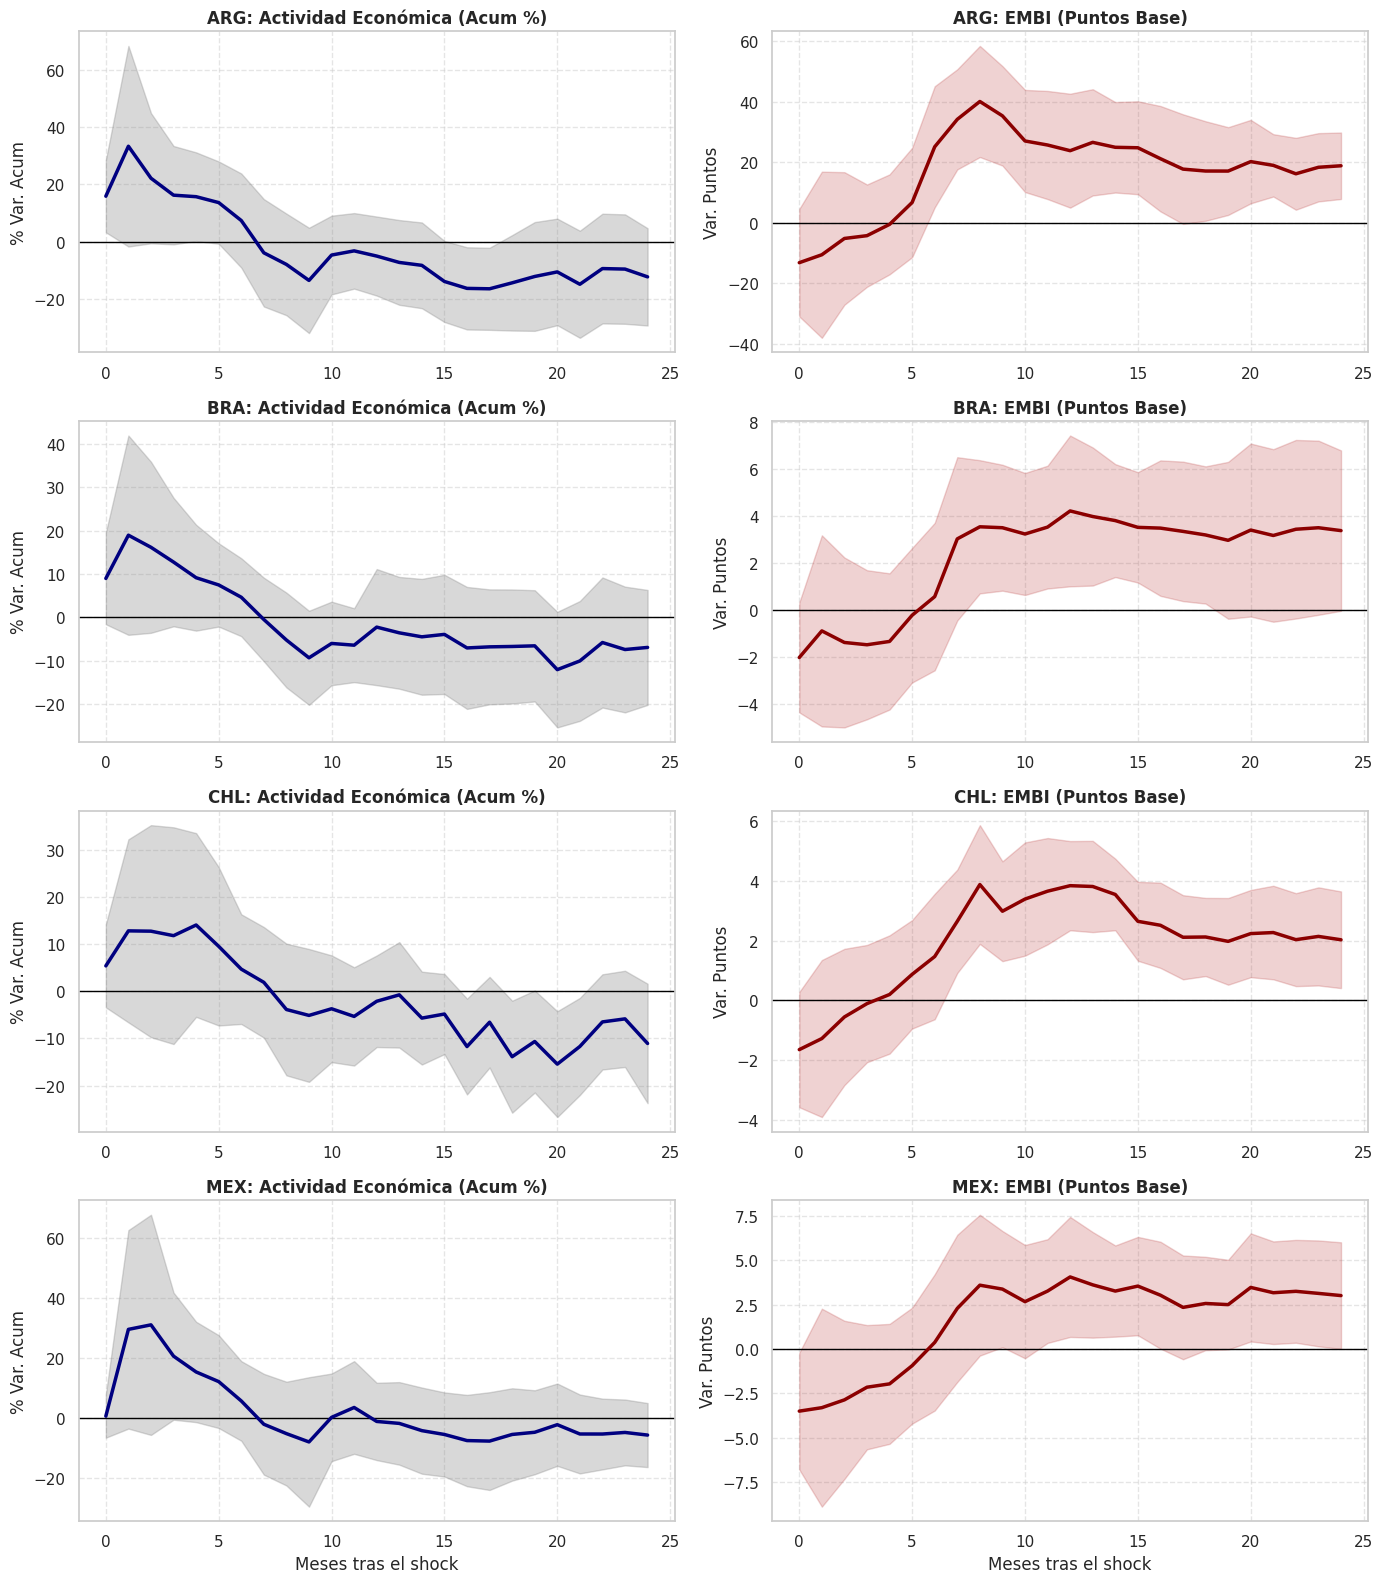

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ==============================================================================
# CONFIGURACIÓN
# ==============================================================================
PAISES = ['ARG', 'BRA', 'CHL', 'MEX']
SHOCK = 'FF4'
H_MAX = 24

# Mapeo de columnas originales (del Excel/Carga) a nombres internos genéricos
MAPA_RAW = {
    'ARG': {'Nivel_Act': 'Actividad_Argentina_Nivel', 'Nivel_EMBI': 'EMBI_Argentina'},
    'BRA': {'Nivel_Act': 'Actividad_Brasil_Nivel',    'Nivel_EMBI': 'EMBI_Brasil'},
    'CHL': {'Nivel_Act': 'Actividad_Chile_Nivel',     'Nivel_EMBI': 'EMBI_Chile'},
    'MEX': {'Nivel_Act': 'Actividad_Mexico_Nivel',    'Nivel_EMBI': 'EMBI_Mexico'}
}

# ==============================================================================
# 1. FUNCIÓN DE PREPARACIÓN ROBUSTA
# ==============================================================================
def preparar_datos_robustos(df_input):
    """
    Genera las variables exactas requeridas para la especificación robusta:
    - ln_Actividad_{Pais}_Nivel
    - d_ln_Actividad_{Pais}  (Crecimiento)
    - d_EMBI_{Pais}          (Variación Riesgo)
    - Lags 1 y 2 de los controles
    """
    df = df_input.copy()
    print("🛠️ Preparando datos para especificación robusta...")

    for pais, cols in MAPA_RAW.items():
        nom_act = cols['Nivel_Act']
        nom_embi = cols['Nivel_EMBI']

        # 1. Log-Nivel Actividad
        col_ln_act = f"ln_Actividad_{pais}_Nivel"
        if col_ln_act not in df.columns:
            df[col_ln_act] = np.log(df[nom_act])

        # 2. Diferencias (Controles base)
        # d_ln_Actividad (Crecimiento aprox)
        col_d_ln_act = f"d_ln_Actividad_{pais}"
        df[col_d_ln_act] = df[col_ln_act].diff() * 100 # Escala porcentual

        # d_EMBI (Variación)
        col_d_embi = f"d_EMBI_{pais}"
        df[col_d_embi] = df[nom_embi].diff()

        # 3. Generar 2 Rezagos de los controles
        vars_control = [col_d_ln_act, col_d_embi]

        for var in vars_control:
            df[f"{var}_lag1"] = df[var].shift(1)
            df[f"{var}_lag2"] = df[var].shift(2)

    print("   ✅ Variables transformadas y rezagos (t-1, t-2) creados.")
    return df

# ==============================================================================
# 2. MOTOR DE ESTIMACIÓN (LP JORDÀ)
# ==============================================================================
def estimar_irf_robusta(df, pais, variable_tipo):
    """
    Estima la IRF para un país y tipo de variable ('Actividad' o 'EMBI').
    Retorna: DataFrame con [h, beta, se, ci_low, ci_up]
    """

    # Definir Nombres de Columnas según el tipo
    col_ln_act = f"ln_Actividad_{pais}_Nivel"
    col_embi = MAPA_RAW[pais]['Nivel_EMBI'] # EMBI en nivel original

    # Controles (Lags 1 y 2 de AMBAS variables domésticas)
    # Especificación estricta: Controlar por dinámica de actividad y riesgo
    ctrl_d_act = f"d_ln_Actividad_{pais}"
    ctrl_d_embi = f"d_EMBI_{pais}"

    lista_controles = [
        f"{ctrl_d_act}_lag1", f"{ctrl_d_act}_lag2",
        f"{ctrl_d_embi}_lag1", f"{ctrl_d_embi}_lag2"
    ]

    # Definir LHS (Nivel base para calcular acumulado)
    if variable_tipo == 'Actividad':
        col_nivel_base = col_ln_act
        es_log = True
    else: # EMBI
        col_nivel_base = col_embi
        es_log = False

    resultados = []

    # Limpieza previa de NaNs en regresores fijos (Shock + Controles)
    cols_reg = [SHOCK] + lista_controles
    df_clean = df.dropna(subset=cols_reg).copy()

    print(f"   Estimando {pais} - {variable_tipo}...")

    for h in range(H_MAX + 1):
        # --- Construcción LHS Acumulada ---
        # y_{t+h} - y_{t-1}
        # Si es Actividad (Log): (ln Y_{t+h} - ln Y_{t-1}) * 100 -> % Acumulado
        # Si es EMBI (Nivel): EMBI_{t+h} - EMBI_{t-1} -> Variación Puntos Acumulada

        y_future = df_clean[col_nivel_base].shift(-h)
        y_past = df_clean[col_nivel_base].shift(1) # t-1

        lhs = y_future - y_past

        if es_log:
            lhs = lhs * 100 # Convertir a puntos porcentuales

        # --- Alineación final y Estimación ---
        # Unir LHS con RHS
        X = df_clean[cols_reg]
        X = sm.add_constant(X)

        data_reg = pd.concat([lhs.rename('LHS'), X], axis=1).dropna()

        if data_reg.empty:
            continue

        # OLS con Newey-West (HAC)
        # maxlags dinámico: h + 1
        model = sm.OLS(data_reg['LHS'], data_reg.drop(columns=['LHS']))
        res = model.fit(cov_type='HAC', cov_kwds={'maxlags': h + 1})

        # Guardar Beta del Shock
        beta = res.params[SHOCK]
        se = res.bse[SHOCK]

        # IC 90% (1.645 * SE)
        z_score = 1.645
        ci_lower = beta - z_score * se
        ci_upper = beta + z_score * se

        resultados.append([h, beta, se, ci_lower, ci_upper])

    return pd.DataFrame(resultados, columns=['h', 'beta', 'se', 'ci_lower', 'ci_upper'])

# ==============================================================================
# 3. GENERACIÓN DE GRÁFICOS (PANEL 4x2)
# ==============================================================================
def plot_panel_robusto(resultados_dict):
    """
    Plotea IRFs en grid 4x2.
    Filas: Países (ARG, BRA, CHL, MEX)
    Col 1: Actividad | Col 2: EMBI
    """
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))

    paises_orden = ['ARG', 'BRA', 'CHL', 'MEX']

    for i, pais in enumerate(paises_orden):
        # --- Actividad ---
        ax_act = axes[i, 0]
        key_act = f"{pais}_Actividad"

        if key_act in resultados_dict:
            df_r = resultados_dict[key_act]

            # Línea Cero
            ax_act.axhline(0, color='black', linewidth=1, linestyle='-')

            # Banda de Confianza 90%
            ax_act.fill_between(df_r['h'], df_r['ci_lower'], df_r['ci_upper'], color='gray', alpha=0.3, label='IC 90%')

            # IRF Media
            ax_act.plot(df_r['h'], df_r['beta'], color='navy', linewidth=2.5, label='IRF Media')

            ax_act.set_title(f"{pais}: Actividad Económica (Acum %)", fontweight='bold')
            ax_act.set_ylabel("% Var. Acum")
            if i == 3: ax_act.set_xlabel("Meses tras el shock")
            ax_act.grid(True, linestyle='--', alpha=0.5)

        # --- EMBI ---
        ax_embi = axes[i, 1]
        key_embi = f"{pais}_EMBI"

        if key_embi in resultados_dict:
            df_r = resultados_dict[key_embi]

            ax_embi.axhline(0, color='black', linewidth=1, linestyle='-')
            ax_embi.fill_between(df_r['h'], df_r['ci_lower'], df_r['ci_upper'], color='firebrick', alpha=0.2, label='IC 90%')
            ax_embi.plot(df_r['h'], df_r['beta'], color='darkred', linewidth=2.5, label='IRF Media')

            ax_embi.set_title(f"{pais}: EMBI (Puntos Base)", fontweight='bold')
            ax_embi.set_ylabel("Var. Puntos")
            if i == 3: ax_embi.set_xlabel("Meses tras el shock")
            ax_embi.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# 4. EJECUCIÓN PRINCIPAL
# ==============================================================================

if 'df' in locals():
    # 1. Preparar
    df_robust = preparar_datos_robustos(df)

    # 2. Estimar
    res_dict = {}
    print("\n🚀 Iniciando estimaciones robustas (HAC, 2 lags)...")

    for pais in PAISES:
        # Actividad
        res_dict[f"{pais}_Actividad"] = estimar_irf_robusta(df_robust, pais, 'Actividad')
        # EMBI
        res_dict[f"{pais}_EMBI"] = estimar_irf_robusta(df_robust, pais, 'EMBI')

    # 3. Graficar
    print("\n📊 Generando Panel de IRFs...")
    plot_panel_robusto(res_dict)

else:
    print("⚠️ DataFrame 'df' no encontrado. Carga los datos primero (carga_de_datos.py).")


🛠️ Preparando datos para especificación robusta (FF1)...
   ✅ Variables transformadas y rezagos (t-1, t-2) creados.

🚀 Iniciando estimaciones robustas para FF1 (HAC, 2 lags)...
   Estimando ARG - Actividad (Shock: FF1)...
   Estimando ARG - EMBI (Shock: FF1)...
   Estimando BRA - Actividad (Shock: FF1)...
   Estimando BRA - EMBI (Shock: FF1)...
   Estimando CHL - Actividad (Shock: FF1)...
   Estimando CHL - EMBI (Shock: FF1)...
   Estimando MEX - Actividad (Shock: FF1)...
   Estimando MEX - EMBI (Shock: FF1)...

📊 Generando Panel de IRFs...


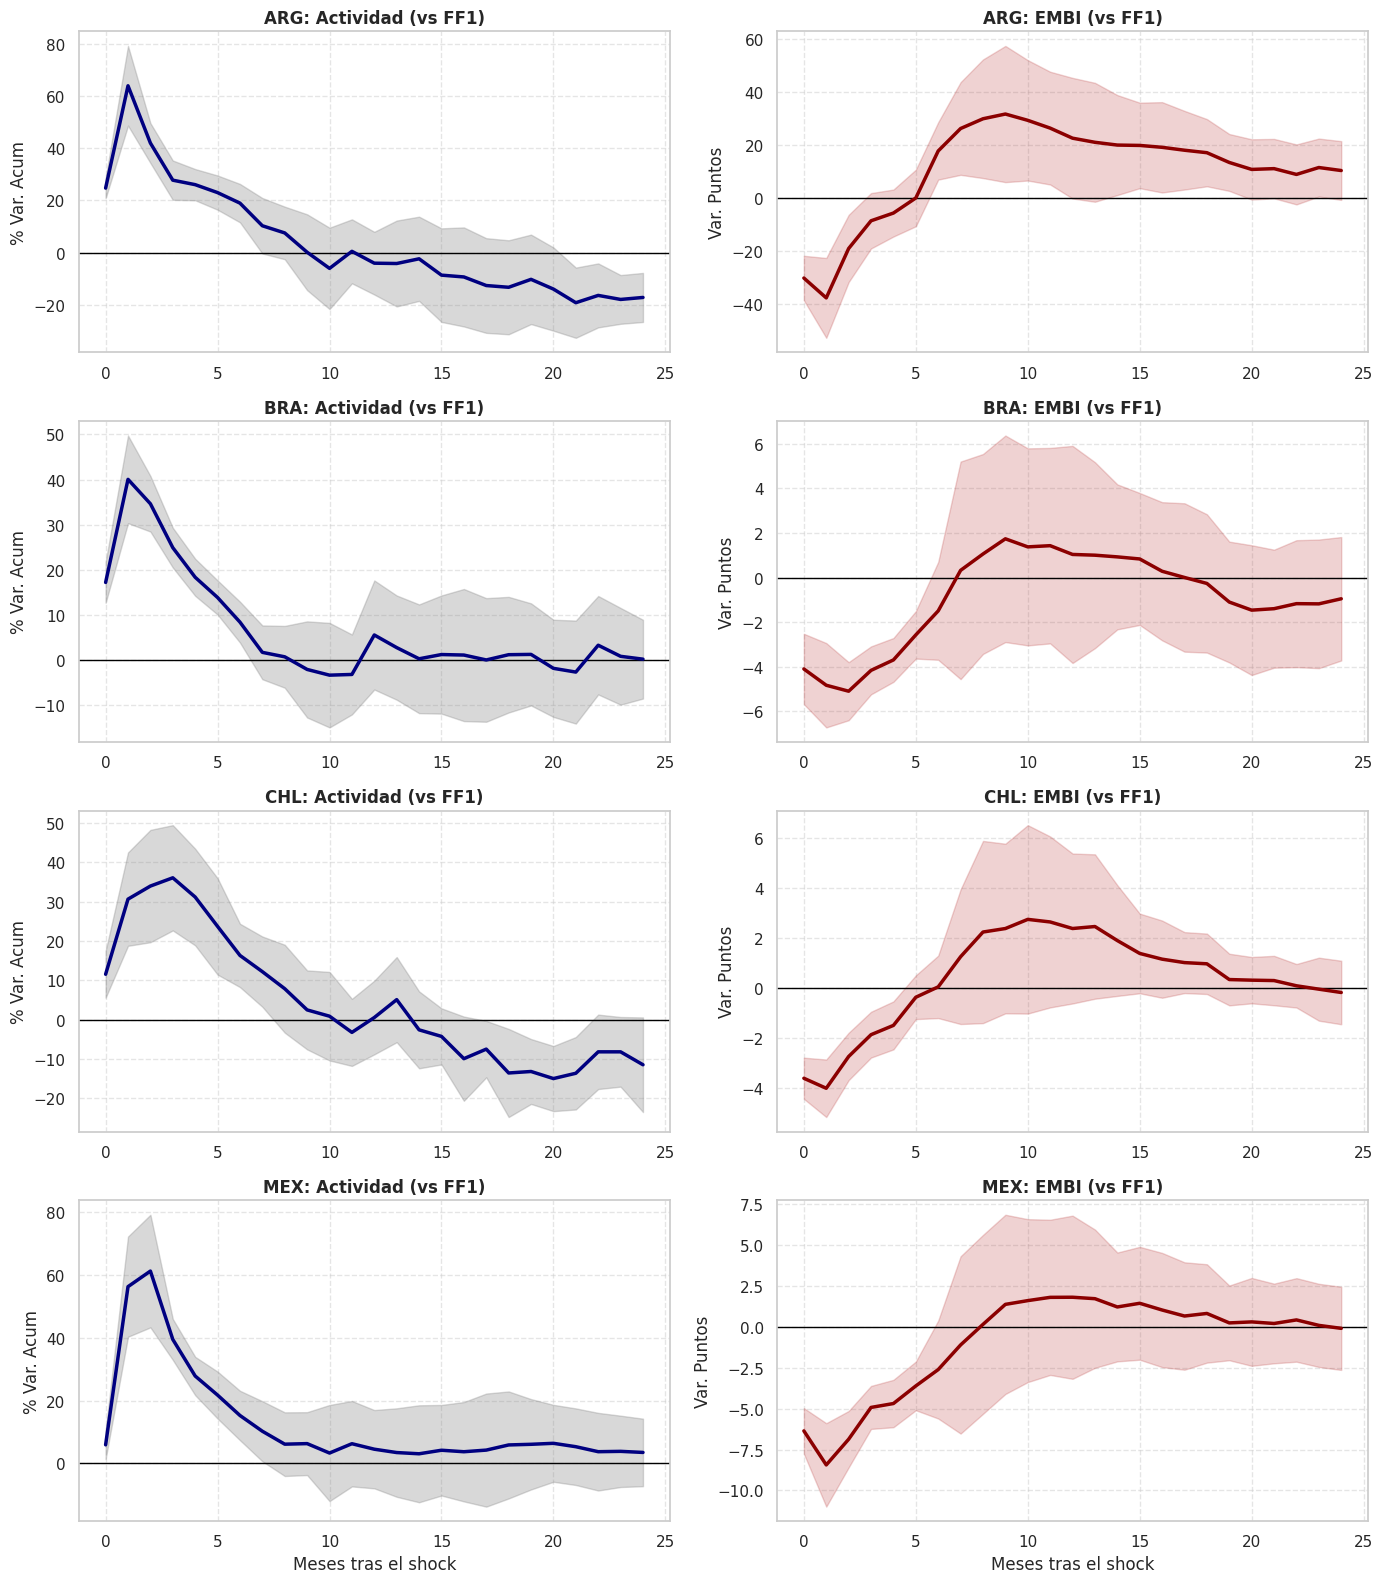

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ==============================================================================
# CONFIGURACIÓN
# ==============================================================================
PAISES = ['ARG', 'BRA', 'CHL', 'MEX']
SHOCK = 'FF1'  # <--- CAMBIO PRINCIPAL AQUÍ
H_MAX = 24

# Mapeo de columnas originales (del Excel/Carga) a nombres internos genéricos
MAPA_RAW = {
    'ARG': {'Nivel_Act': 'Actividad_Argentina_Nivel', 'Nivel_EMBI': 'EMBI_Argentina'},
    'BRA': {'Nivel_Act': 'Actividad_Brasil_Nivel',    'Nivel_EMBI': 'EMBI_Brasil'},
    'CHL': {'Nivel_Act': 'Actividad_Chile_Nivel',     'Nivel_EMBI': 'EMBI_Chile'},
    'MEX': {'Nivel_Act': 'Actividad_Mexico_Nivel',    'Nivel_EMBI': 'EMBI_Mexico'}
}

# ==============================================================================
# 1. FUNCIÓN DE PREPARACIÓN ROBUSTA
# ==============================================================================
def preparar_datos_robustos(df_input):
    """
    Genera las variables exactas requeridas para la especificación robusta:
    - ln_Actividad_{Pais}_Nivel
    - d_ln_Actividad_{Pais}  (Crecimiento)
    - d_EMBI_{Pais}          (Variación Riesgo)
    - Lags 1 y 2 de los controles
    """
    df = df_input.copy()
    print("🛠️ Preparando datos para especificación robusta (FF1)...")

    for pais, cols in MAPA_RAW.items():
        nom_act = cols['Nivel_Act']
        nom_embi = cols['Nivel_EMBI']

        # 1. Log-Nivel Actividad
        col_ln_act = f"ln_Actividad_{pais}_Nivel"
        if col_ln_act not in df.columns:
            df[col_ln_act] = np.log(df[nom_act])

        # 2. Diferencias (Controles base)
        # d_ln_Actividad (Crecimiento aprox)
        col_d_ln_act = f"d_ln_Actividad_{pais}"
        df[col_d_ln_act] = df[col_ln_act].diff() * 100 # Escala porcentual

        # d_EMBI (Variación)
        col_d_embi = f"d_EMBI_{pais}"
        df[col_d_embi] = df[nom_embi].diff()

        # 3. Generar 2 Rezagos de los controles
        vars_control = [col_d_ln_act, col_d_embi]

        for var in vars_control:
            df[f"{var}_lag1"] = df[var].shift(1)
            df[f"{var}_lag2"] = df[var].shift(2)

    print("   ✅ Variables transformadas y rezagos (t-1, t-2) creados.")
    return df

# ==============================================================================
# 2. MOTOR DE ESTIMACIÓN (LP JORDÀ)
# ==============================================================================
def estimar_irf_robusta(df, pais, variable_tipo):
    """
    Estima la IRF para un país y tipo de variable ('Actividad' o 'EMBI').
    Retorna: DataFrame con [h, beta, se, ci_low, ci_up]
    """

    # Definir Nombres de Columnas según el tipo
    col_ln_act = f"ln_Actividad_{pais}_Nivel"
    col_embi = MAPA_RAW[pais]['Nivel_EMBI'] # EMBI en nivel original

    # Controles (Lags 1 y 2 de AMBAS variables domésticas)
    # Especificación estricta: Controlar por dinámica de actividad y riesgo
    ctrl_d_act = f"d_ln_Actividad_{pais}"
    ctrl_d_embi = f"d_EMBI_{pais}"

    lista_controles = [
        f"{ctrl_d_act}_lag1", f"{ctrl_d_act}_lag2",
        f"{ctrl_d_embi}_lag1", f"{ctrl_d_embi}_lag2"
    ]

    # Definir LHS (Nivel base para calcular acumulado)
    if variable_tipo == 'Actividad':
        col_nivel_base = col_ln_act
        es_log = True
    else: # EMBI
        col_nivel_base = col_embi
        es_log = False

    resultados = []

    # Limpieza previa de NaNs en regresores fijos (Shock + Controles)
    # Importante: Asegurarse de que el shock existe en el df
    if SHOCK not in df.columns:
        print(f"❌ Error: La variable de shock '{SHOCK}' no está en el DataFrame.")
        return pd.DataFrame() # Retorno vacío

    cols_reg = [SHOCK] + lista_controles
    df_clean = df.dropna(subset=cols_reg).copy()

    print(f"   Estimando {pais} - {variable_tipo} (Shock: {SHOCK})...")

    for h in range(H_MAX + 1):
        # --- Construcción LHS Acumulada ---
        # y_{t+h} - y_{t-1}

        y_future = df_clean[col_nivel_base].shift(-h)
        y_past = df_clean[col_nivel_base].shift(1) # t-1

        lhs = y_future - y_past

        if es_log:
            lhs = lhs * 100 # Convertir a puntos porcentuales

        # --- Alineación final y Estimación ---
        # Unir LHS con RHS
        X = df_clean[cols_reg]
        X = sm.add_constant(X)

        data_reg = pd.concat([lhs.rename('LHS'), X], axis=1).dropna()

        if data_reg.empty:
            continue

        # OLS con Newey-West (HAC)
        # maxlags dinámico: h + 1
        model = sm.OLS(data_reg['LHS'], data_reg.drop(columns=['LHS']))
        res = model.fit(cov_type='HAC', cov_kwds={'maxlags': h + 1})

        # Guardar Beta del Shock
        beta = res.params[SHOCK]
        se = res.bse[SHOCK]

        # IC 90% (1.645 * SE)
        z_score = 1.645
        ci_lower = beta - z_score * se
        ci_upper = beta + z_score * se

        resultados.append([h, beta, se, ci_lower, ci_upper])

    return pd.DataFrame(resultados, columns=['h', 'beta', 'se', 'ci_lower', 'ci_upper'])

# ==============================================================================
# 3. GENERACIÓN DE GRÁFICOS (PANEL 4x2)
# ==============================================================================
def plot_panel_robusto(resultados_dict):
    """
    Plotea IRFs en grid 4x2.
    Filas: Países (ARG, BRA, CHL, MEX)
    Col 1: Actividad | Col 2: EMBI
    """
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))

    paises_orden = ['ARG', 'BRA', 'CHL', 'MEX']

    for i, pais in enumerate(paises_orden):
        # --- Actividad ---
        ax_act = axes[i, 0]
        key_act = f"{pais}_Actividad"

        if key_act in resultados_dict:
            df_r = resultados_dict[key_act]
            if not df_r.empty:
                # Línea Cero
                ax_act.axhline(0, color='black', linewidth=1, linestyle='-')

                # Banda de Confianza 90%
                ax_act.fill_between(df_r['h'], df_r['ci_lower'], df_r['ci_upper'], color='gray', alpha=0.3, label='IC 90%')

                # IRF Media
                ax_act.plot(df_r['h'], df_r['beta'], color='navy', linewidth=2.5, label='IRF Media')

                ax_act.set_title(f"{pais}: Actividad (vs {SHOCK})", fontweight='bold') # Título Actualizado
                ax_act.set_ylabel("% Var. Acum")
                if i == 3: ax_act.set_xlabel("Meses tras el shock")
                ax_act.grid(True, linestyle='--', alpha=0.5)

        # --- EMBI ---
        ax_embi = axes[i, 1]
        key_embi = f"{pais}_EMBI"

        if key_embi in resultados_dict:
            df_r = resultados_dict[key_embi]
            if not df_r.empty:
                ax_embi.axhline(0, color='black', linewidth=1, linestyle='-')
                ax_embi.fill_between(df_r['h'], df_r['ci_lower'], df_r['ci_upper'], color='firebrick', alpha=0.2, label='IC 90%')
                ax_embi.plot(df_r['h'], df_r['beta'], color='darkred', linewidth=2.5, label='IRF Media')

                ax_embi.set_title(f"{pais}: EMBI (vs {SHOCK})", fontweight='bold') # Título Actualizado
                ax_embi.set_ylabel("Var. Puntos")
                if i == 3: ax_embi.set_xlabel("Meses tras el shock")
                ax_embi.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# 4. EJECUCIÓN PRINCIPAL
# ==============================================================================

if 'df' in locals():
    # 1. Preparar
    df_robust = preparar_datos_robustos(df)

    # 2. Estimar
    res_dict = {}
    print(f"\n🚀 Iniciando estimaciones robustas para {SHOCK} (HAC, 2 lags)...")

    for pais in PAISES:
        # Actividad
        res_dict[f"{pais}_Actividad"] = estimar_irf_robusta(df_robust, pais, 'Actividad')
        # EMBI
        res_dict[f"{pais}_EMBI"] = estimar_irf_robusta(df_robust, pais, 'EMBI')

    # 3. Graficar
    print("\n📊 Generando Panel de IRFs...")
    plot_panel_robusto(res_dict)

else:
    print("⚠️ DataFrame 'df' no encontrado. Carga los datos primero (carga_de_datos.py).")
